In [8]:
#https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/
import tensorflow as tf

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0' # Set to -1 if CPU should be used CPU = -1 , GPU = 0

gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
elif cpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        logical_cpus= tf.config.experimental.list_logical_devices('CPU')
        print(len(cpus), "Physical CPU,", len(logical_cpus), "Logical CPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [9]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay          69G   33G   37G  48% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.8G     0  5.8G   0% /dev/shm
/dev/sda1        75G   34G   42G  45% /opt/bin
tmpfs           6.4G   16K  6.4G   1% /var/colab
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware


In [10]:
# +Add data before loading

!wget -O gdrivedl 'https://f.mjh.nz/gdrivedl'
!ls -l
!pwd
"""
!bash /kaggle/working/gdrivedl https://drive.google.com/file/d/11KqozCisBLjEwfNalFSq85sf_XYJDU1K/view?usp=sharing
!ls -l /kaggle/working
inputdir = "/kaggle/working"
"""
!bash /content/gdrivedl https://drive.google.com/file/d/11KqozCisBLjEwfNalFSq85sf_XYJDU1K/view?usp=sharing
!ls -l /content/
inputdir = "/content"

--2020-12-12 21:17:22--  https://f.mjh.nz/gdrivedl
Resolving f.mjh.nz (f.mjh.nz)... 172.67.162.157, 104.28.31.233, 104.28.30.233, ...
Connecting to f.mjh.nz (f.mjh.nz)|172.67.162.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1362 (1.3K) [application/octet-stream]
Saving to: ‘gdrivedl’

gdrivedl            100%[===================>]   1.33K  --.-KB/s    in 0s      

2020-12-12 21:17:22 (29.9 MB/s) - ‘gdrivedl’ saved [1362/1362]

total 8
-rw-r--r-- 1 root root 1362 Jan 29  2019 gdrivedl
drwxr-xr-x 1 root root 4096 Dec  2 22:04 sample_data
/content
File ID: 11KqozCisBLjEwfNalFSq85sf_XYJDU1K
Downloading: https://docs.google.com/uc?export=download&id=11KqozCisBLjEwfNalFSq85sf_XYJDU1K > .136.file
Downloading: https://docs.google.com/uc?export=download&id=11KqozCisBLjEwfNalFSq85sf_XYJDU1K&confirm=8pRE > .136.file
Moving: .136.file > Food-11.zip
Saved: Food-11.zip
DONE!
total 1135708
-rw-r--r-- 1 root root 1162949981 Dec 12 21:17 Food-11.zip
-rw-r--r-- 1 root ro

In [11]:
# import the necessary packages
import os

# initialize the path to the *original* input directory of images
ORIG_INPUT_DATASET = os.path.join(inputdir, "Food-11.zip")

# initialize the base path to the *new* directory that will contain
# our images after computing the training and testing split
#BASE_PATH = "dataset1"
import tempfile
TEMPDIR = tempfile.gettempdir()
BASE_PATH = os.path.join(TEMPDIR, "dataset1.zip")

# define the names of the training, testing, and validation
# directories
TRAIN = "training1"
TEST = "evaluation1"
VAL = "validation1"

# initialize the list of class label names
CLASSES = ["Bread", "Dairy product", "Dessert", "Egg", "Fried food","Meat", "Noodles/Pasta", "Rice", "Seafood", "Soup","Vegetable/Fruit"]

# set the batch size when fine-tuning
BATCH_SIZE = 12 #32, small batch size for 3GB NVIDIA GeForce 1060 3GB

# initialize the label encoder file path and the output directory to
# where the extracted features (in CSV file format) will be stored
#LE_PATH = os.path.sep.join(["output1", "le.cpickle"])
#BASE_CSV_PATH = "output1"

LE_PATH = os.path.sep.join([TEMPDIR, "le1.pkl"])
BASE_CSV_PATH = TEMPDIR

# set the path to the serialized model after training
#MODEL_PATH = os.path.sep.join(["output1", "food11.model"])
MODEL_PATH = os.path.sep.join([TEMPDIR, "food11.h5"])

# define the path to the output training history plots
#UNFROZEN_PLOT_PATH = os.path.sep.join(["output1", "unfrozen.png"])
#WARMUP_PLOT_PATH = os.path.sep.join(["output1", "warmup.png"])
UNFROZEN_PLOT_PATH = os.path.sep.join([TEMPDIR, "unfrozen.png"])
WARMUP_PLOT_PATH = os.path.sep.join([TEMPDIR, "warmup.png"])

In [12]:
!pip install imutils

In [13]:
# import the necessary packages
from imutils import paths
import shutil
import os
# import the necessary packages
from keras.models import load_model
import numpy as np
import argparse
import imutils
import cv2
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [14]:
import zipfile
import cv2
zf = zipfile.ZipFile(ORIG_INPUT_DATASET)
imagelist = zf.namelist()

ozf = zipfile.ZipFile(BASE_PATH, 'w')

classcountdict = {}

# loop over the data splits
for split in (TRAIN, TEST, VAL):
	# grab all image paths in the current split
	print("[INFO] processing '{} split'...".format(split))
	#p = os.path.sep.join([ORIG_INPUT_DATASET, split])
	#imagePaths = list(paths.list_images(p))
	imagePaths = [ix for ix in imagelist if ix.startswith(split)]

	# loop over the image paths
	for imagePath in imagePaths:
		# extract class label from the filename
		#filename = imagePath.split(os.path.sep)[-1]
		#label = CLASSES[int(filename.split("_")[0])]
		filename = imagePath.rsplit('/', 1)[-1]
		label = CLASSES[int(filename.split("_")[0])]
		classcountdict.setdefault(label, 0)
		classcountdict[label] += 1

		# construct the path to the output directory
		dirPath = os.path.sep.join([BASE_PATH, split, label])
		dirPath = '/'.join([split, label])

		# if the output directory does not exist, create it
		#if not os.path.exists(dirPath):
		#	os.makedirs(dirPath)

		# construct the path to the output image file and copy it
		#p = os.path.sep.join([dirPath, filename])
		#shutil.copy2(imagePath, p)
		ozf.writestr(dirPath + '/' + filename, zf.read(imagePath), compress_type=zipfile.ZIP_STORED)
	#print(len(imagePaths))
zf.close()
ozf.close()

[INFO] processing 'training1 split'...
[INFO] processing 'evaluation1 split'...
[INFO] processing 'validation1 split'...


In [15]:
print(CLASSES)
print([classcountdict[ix] for ix in CLASSES])

['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles/Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable/Fruit']
[1724, 721, 2500, 1648, 1461, 2206, 734, 472, 1505, 2500, 1172]


In [16]:
def plot_training(H, N, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
	plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
	plt.plot(np.arange(0, N), H.history["accuracy"], label="train_accuracy")
	plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_accuracy")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)

In [17]:
# derive the paths to the training, validation, and testing directories
#trainPath = os.path.sep.join([BASE_PATH, TRAIN])
#valPath = os.path.sep.join([BASE_PATH, VAL])
#testPath = os.path.sep.join([BASE_PATH, TEST])

# determine the total number of image paths in training, validation,
# and testing directories
#totalTrain = len(list(paths.list_images(trainPath)))
#totalVal = len(list(paths.list_images(valPath)))
#totalTest = len(list(paths.list_images(testPath)))

from keras.applications import imagenet_utils
import cv2
zf = zipfile.ZipFile(BASE_PATH)
imagelist = zf.namelist()
#print(len(imagelist))
#print(imagelist[:5])

imageTrain = []
imageVal = []
imageTest = []
labelTrain = []
labelVal = []
labelTest = []

#print(TRAIN, TEST, VAL)

# loop over the data splits
for split in (TRAIN, TEST, VAL):
	# grab all image paths in the current split
	print("[INFO] processing '{} split'...".format(split))
	#p = os.path.sep.join([BASE_PATH, split])
	#imagePaths = list(paths.list_images(p))
	imagePaths = [ix for ix in imagelist if ix.startswith(split)]
	# loop over the images in batches
	#print(split, len(imagePaths))
	print("[INFO] processing '{} images'...".format(len(imagePaths)))
	#for imagePath in imagePaths:
	import random
	random.shuffle(imagePaths) # shuffle imagePaths
	for imagePath in imagePaths[:1000]: # only for 1000 images, too big to handle in colab and kaggle
		# load the input image using the Keras helper utility
		# while ensuring the image is resized to 224x224 pixels
		#image = load_img(imagePath, target_size=(224, 224))
		#image = img_to_array(image)
		#print(imagePath)
		image = cv2.imdecode(np.frombuffer(zf.read(imagePath), np.uint8), 1)
		image = cv2.resize(image, (224, 224))
		image = np.expand_dims(image, axis=0)
		image = imagenet_utils.preprocess_input(image)
		label, filename = imagePath.rsplit('/', 1)
		imageclass, label = label.split('/', 1)
		if imageclass == TRAIN:
			imageTrain.append(image)
			labelTrain.append(CLASSES.index(label))
		if imageclass == VAL:
			imageVal.append(image)
			labelVal.append(CLASSES.index(label))
		if imageclass == TEST:
			imageTest.append(image)
			labelTest.append(CLASSES.index(label))
	print(imageclass, len(imagePaths))
	print(imageclass, len(imagePaths))
	#if imageclass == TRAIN: imageTrain = np.vstack(imageTrain)
	#if imageclass == VAL: imageVal = np.vstack(imageVal)
	#if imageclass == TEST: imageTest = np.vstack(imageTest)
zf.close()

imageTrain = np.vstack(imageTrain)
imageVal = np.vstack(imageVal)
imageTest = np.vstack(imageTest)
from tensorflow.keras.utils import to_categorical
labelTrain = to_categorical(labelTrain)
labelVal = to_categorical(labelVal)
labelTest = to_categorical(labelTest)
print(split, len(imageTrain), len(imageVal), len(imageTest))
print(split, len(labelTrain), len(labelVal), len(labelTest))

[INFO] processing 'training1 split'...
[INFO] processing '9866 images'...
training1 9866
training1 9866
[INFO] processing 'evaluation1 split'...
[INFO] processing '3347 images'...
evaluation1 3347
evaluation1 3347
[INFO] processing 'validation1 split'...
[INFO] processing '3430 images'...
validation1 3430
validation1 3430
validation1 1000 1000 1000
validation1 1000 1000 1000


In [18]:
#imageTrain = np.vstack(imageTrain)
#imageVal = np.vstack(imageVal)
#imageTest = np.vstack(imageTest)
print(labelTrain[:5])
print(labelVal[:5])
print(labelTest[:5])

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [19]:
print(imageTrain.shape)
print(imageVal.shape)
print(imageTest.shape)
print(len(imageTrain))
print(len(imageVal))
print(len(imageTest))

(1000, 224, 224, 3)
(1000, 224, 224, 3)
(1000, 224, 224, 3)
1000
1000
1000


In [20]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=30,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,fill_mode="nearest")

In [21]:
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()

In [22]:
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [23]:
# initialize the training generator
#trainGen = trainAug.flow_from_directory(trainPath,class_mode="categorical",target_size=(224, 224),color_mode="rgb",shuffle=True,batch_size=BATCH_SIZE)
trainGen = trainAug.flow(imageTrain, y = labelTrain, shuffle=True,batch_size=BATCH_SIZE)

In [24]:
# initialize the validation generator
#valGen = valAug.flow_from_directory(valPath,class_mode="categorical",target_size=(224, 224),color_mode="rgb",shuffle=False,batch_size=BATCH_SIZE)
valGen = valAug.flow(imageVal, y = labelVal, shuffle=False,batch_size=BATCH_SIZE)

In [25]:
# initialize the testing generator
#testGen = valAug.flow_from_directory(testPath,class_mode="categorical",target_size=(224, 224),color_mode="rgb",shuffle=False,batch_size=BATCH_SIZE)
testGen = valAug.flow(imageTest, y = labelTest, shuffle=False,batch_size=BATCH_SIZE)

In [26]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

58892288/58889256 [==============================] - 0s 0us/step


In [27]:
print(baseModel.output.shape)

(None, 7, 7, 512)


In [28]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(CLASSES), activation="softmax")(headModel)

In [29]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [30]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [31]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable
print("[INFO] compiling model...")
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] compiling model...


In [32]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [33]:
# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
totalTrain = len(imageTrain)
totalVal = len(imageVal)
totalTest = len(imageTest)
print("[INFO] training head...")
H = model.fit(trainGen,steps_per_epoch=totalTrain // BATCH_SIZE,validation_data=valGen,validation_steps=totalVal // BATCH_SIZE,epochs=100)
# TOO LONG CALCULATIOIN TIME

[INFO] training head...
Epoch 1/100
83/83 [==============================] - 16s 196ms/step - loss: 14.2782 - accuracy: 0.2480 - val_loss: 3.0132 - val_accuracy: 0.4799
Epoch 2/100
83/83 [==============================] - 16s 190ms/step - loss: 2.7338 - accuracy: 0.3512 - val_loss: 1.8949 - val_accuracy: 0.4317
Epoch 3/100
83/83 [==============================] - 16s 189ms/step - loss: 2.1057 - accuracy: 0.3603 - val_loss: 1.7083 - val_accuracy: 0.5060
Epoch 4/100
83/83 [==============================] - 16s 193ms/step - loss: 1.9627 - accuracy: 0.4170 - val_loss: 1.5672 - val_accuracy: 0.5171
Epoch 5/100
83/83 [==============================] - 16s 192ms/step - loss: 1.7620 - accuracy: 0.4291 - val_loss: 1.5468 - val_accuracy: 0.5191
Epoch 6/100
83/83 [==============================] - 16s 192ms/step - loss: 1.7637 - accuracy: 0.4231 - val_loss: 1.4550 - val_accuracy: 0.5452
Epoch 7/100
83/83 [==============================] - 16s 193ms/step - loss: 1.6504 - accuracy: 0.4565 - val_los

[INFO] evaluating after fine-tuning network head...


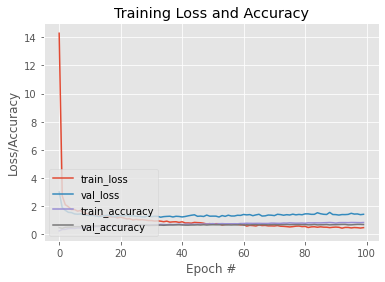

In [34]:
# reset the testing generator and evaluate the network after
# fine-tuning just the network head
print("[INFO] evaluating after fine-tuning network head...")
testGen.reset()
predIdxs = model.predict(testGen,steps=(totalTest // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
#print(classification_report(testGen.classes, predIdxs,target_names=testGen.class_indices.keys()))
plot_training(H, 100, WARMUP_PLOT_PATH)

In [35]:
# reset our data generators
trainGen.reset()
valGen.reset()

In [36]:
# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
for layer in baseModel.layers[15:]:
	layer.trainable = True

In [37]:
# loop over the layers in the model and show which ones are trainable
# or not
for layer in baseModel.layers:
	print("{}: {}".format(layer, layer.trainable))

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f2809842cc0>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2807c8dd68>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2808e981d0>: False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f2808e988d0>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2808ee70f0>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2808ee7b70>: False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f2808f0e2b0>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2808f0eb00>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2808e6a978>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2808e6aa58>: False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f2808e57978>: False
<tensorflow.python.keras.layers.convolutional.Conv2D

In [38]:
# for the changes to the model to take affect we need to recompile
# the model, this time using SGD with a *very* small learning rate
print("[INFO] re-compiling model...")
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] re-compiling model...


In [39]:
# train the model again, this time fine-tuning *both* the final set
# of CONV layers along with our set of FC layers
H = model.fit(trainGen,steps_per_epoch=totalTrain // BATCH_SIZE,validation_data=valGen,validation_steps=totalVal // BATCH_SIZE,epochs=50)

Epoch 1/50
83/83 [==============================] - 16s 198ms/step - loss: 0.5591 - accuracy: 0.8249 - val_loss: 1.5129 - val_accuracy: 0.6857
Epoch 2/50
83/83 [==============================] - 16s 194ms/step - loss: 0.5711 - accuracy: 0.8107 - val_loss: 1.5775 - val_accuracy: 0.6787
Epoch 3/50
83/83 [==============================] - 16s 194ms/step - loss: 0.6071 - accuracy: 0.8178 - val_loss: 1.4694 - val_accuracy: 0.6727
Epoch 4/50
83/83 [==============================] - 16s 194ms/step - loss: 0.6252 - accuracy: 0.7945 - val_loss: 1.3517 - val_accuracy: 0.6817
Epoch 5/50
83/83 [==============================] - 16s 194ms/step - loss: 0.4784 - accuracy: 0.8310 - val_loss: 1.4588 - val_accuracy: 0.6958
Epoch 6/50
83/83 [==============================] - 16s 196ms/step - loss: 0.4762 - accuracy: 0.8370 - val_loss: 1.2841 - val_accuracy: 0.7058
Epoch 7/50
83/83 [==============================] - 16s 194ms/step - loss: 0.4104 - accuracy: 0.8664 - val_loss: 1.2312 - val_accuracy: 0.7219

[INFO] evaluating after fine-tuning network...


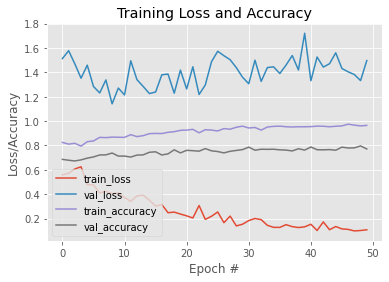

In [43]:
# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating after fine-tuning network...")
testGen.reset()
predIdxs = model.predict(testGen,steps=(totalTest // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
#print(classification_report(testGen.classes, predIdxs,target_names=testGen.class_indices.keys()))
plot_training(H, 50, UNFROZEN_PLOT_PATH)

In [44]:
# serialize the model to disk
print("[INFO] serializing network...")
model.save(MODEL_PATH)

[INFO] serializing network...


In [45]:
import zipfile
import cv2
zf = zipfile.ZipFile(BASE_PATH)
imagelist = zf.namelist()

# load the input image and then clone it so we can draw on it later
#image = cv2.imread(args["image"])
imagename = 'evaluation1/Dessert/2_100.jpg'
image = cv2.imdecode(np.frombuffer(zf.read(imagename), np.uint8), 1)

#output = image.copy()
#output = imutils.resize(output, width=400)

output = imutils.resize(image, width=400)

In [46]:
# our model was trained on RGB ordered images but OpenCV represents
# images in BGR order, so swap the channels, and then resize to
# 224x224 (the input dimensions for VGG16)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))

In [47]:
# convert the image to a floating point data type and perform mean
# subtraction
image = image.astype("float32")
mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")
image -= mean

In [48]:
# load the trained model from disk
print("[INFO] loading model...")
model = load_model(MODEL_PATH)

[INFO] loading model...


In [49]:
# pass the image through the network to obtain our predictions
preds = model.predict(np.expand_dims(image, axis=0))[0]
i = np.argmax(preds)
label = CLASSES[i]

In [50]:
# draw the prediction on the output image
text = "{}: {:.2f}%".format(label, preds[i] * 100)
cv2.putText(output, text, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

array([[[ 12,  12,  18],
        [ 13,  13,  19],
        [ 14,  14,  20],
        ...,
        [ 10,  11,  15],
        [ 11,  12,  16],
        [ 11,  12,  16]],

       [[ 13,  13,  19],
        [ 14,  14,  20],
        [ 14,  14,  20],
        ...,
        [ 10,  11,  15],
        [ 10,  11,  15],
        [ 11,  12,  16]],

       [[ 14,  14,  20],
        [ 14,  14,  20],
        [ 14,  14,  20],
        ...,
        [ 10,  11,  15],
        [ 10,  11,  15],
        [ 10,  11,  15]],

       ...,

       [[122, 131, 145],
        [137, 146, 160],
        [132, 141, 155],
        ...,
        [100, 102, 110],
        [100, 102, 110],
        [ 99, 101, 109]],

       [[127, 136, 150],
        [134, 143, 157],
        [139, 148, 162],
        ...,
        [100, 102, 110],
        [ 99, 101, 109],
        [ 99, 101, 109]],

       [[128, 137, 151],
        [129, 138, 152],
        [139, 148, 162],
        ...,
        [100, 102, 110],
        [ 99, 101, 109],
        [ 99, 101, 109]]

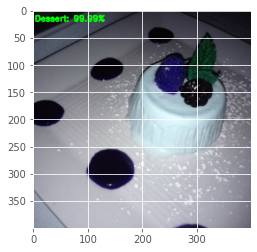

In [51]:
# show the output image
#cv2.imshow("Output", output)
#cv2.waitKey(0)
plt.imshow(output)